In [149]:
import os
import sys
import joblib
import pandas as pd
import seaborn as sb
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from vpq.utils import SV, GT, size_bin, SZBINS
from pandas.api.types import CategoricalDtype
import glob

sb.set(style="whitegrid")
basedir=os.environ["VPQDAT"]

In [99]:
test_files = ["quint.chr3p21.2.jl", "quint.chr2p13.1.jl", "quint.chr15p11.2.jl"]
files = glob.glob(basedir + "/*.jl")
#data = pd.concat([joblib.load(os.path.join(basedir, x))["table"] for x in ])
data = []
for _ in files:
    d = joblib.load(os.path.join(basedir, _))["table"]
    if d.shape[0]: # has rows
        data.append(d)
data = pd.concat(data)
samps = joblib.load(os.path.join(basedir, test_files[0]))["samples"]
data["size_bin"] = data["svlen"].apply(size_bin)

In [100]:
# PER sample GT frequencies 
sys.stdout.write("samp")
for i in GT:
    sys.stdout.write("\t" + i.name)
sys.stdout.write("\n")
for i in samps:
    sys.stdout.write(i)
    mcnt = Counter(data[i + "_gt"])
    for k in GT:
        sys.stdout.write("\t%d" % (mcnt[k.value]))
    sys.stdout.write("\n")


samp	NON	REF	HET	HOM	UNK
Rep0	1601955	253543	2590435	2164575	0
Rep1	1423962	258441	2822135	2105970	0
Rep2	1424367	250174	2822975	2112992	0
Rep3	1374423	262983	2856391	2116711	0
Rep4	1386491	260975	2846501	2116541	0


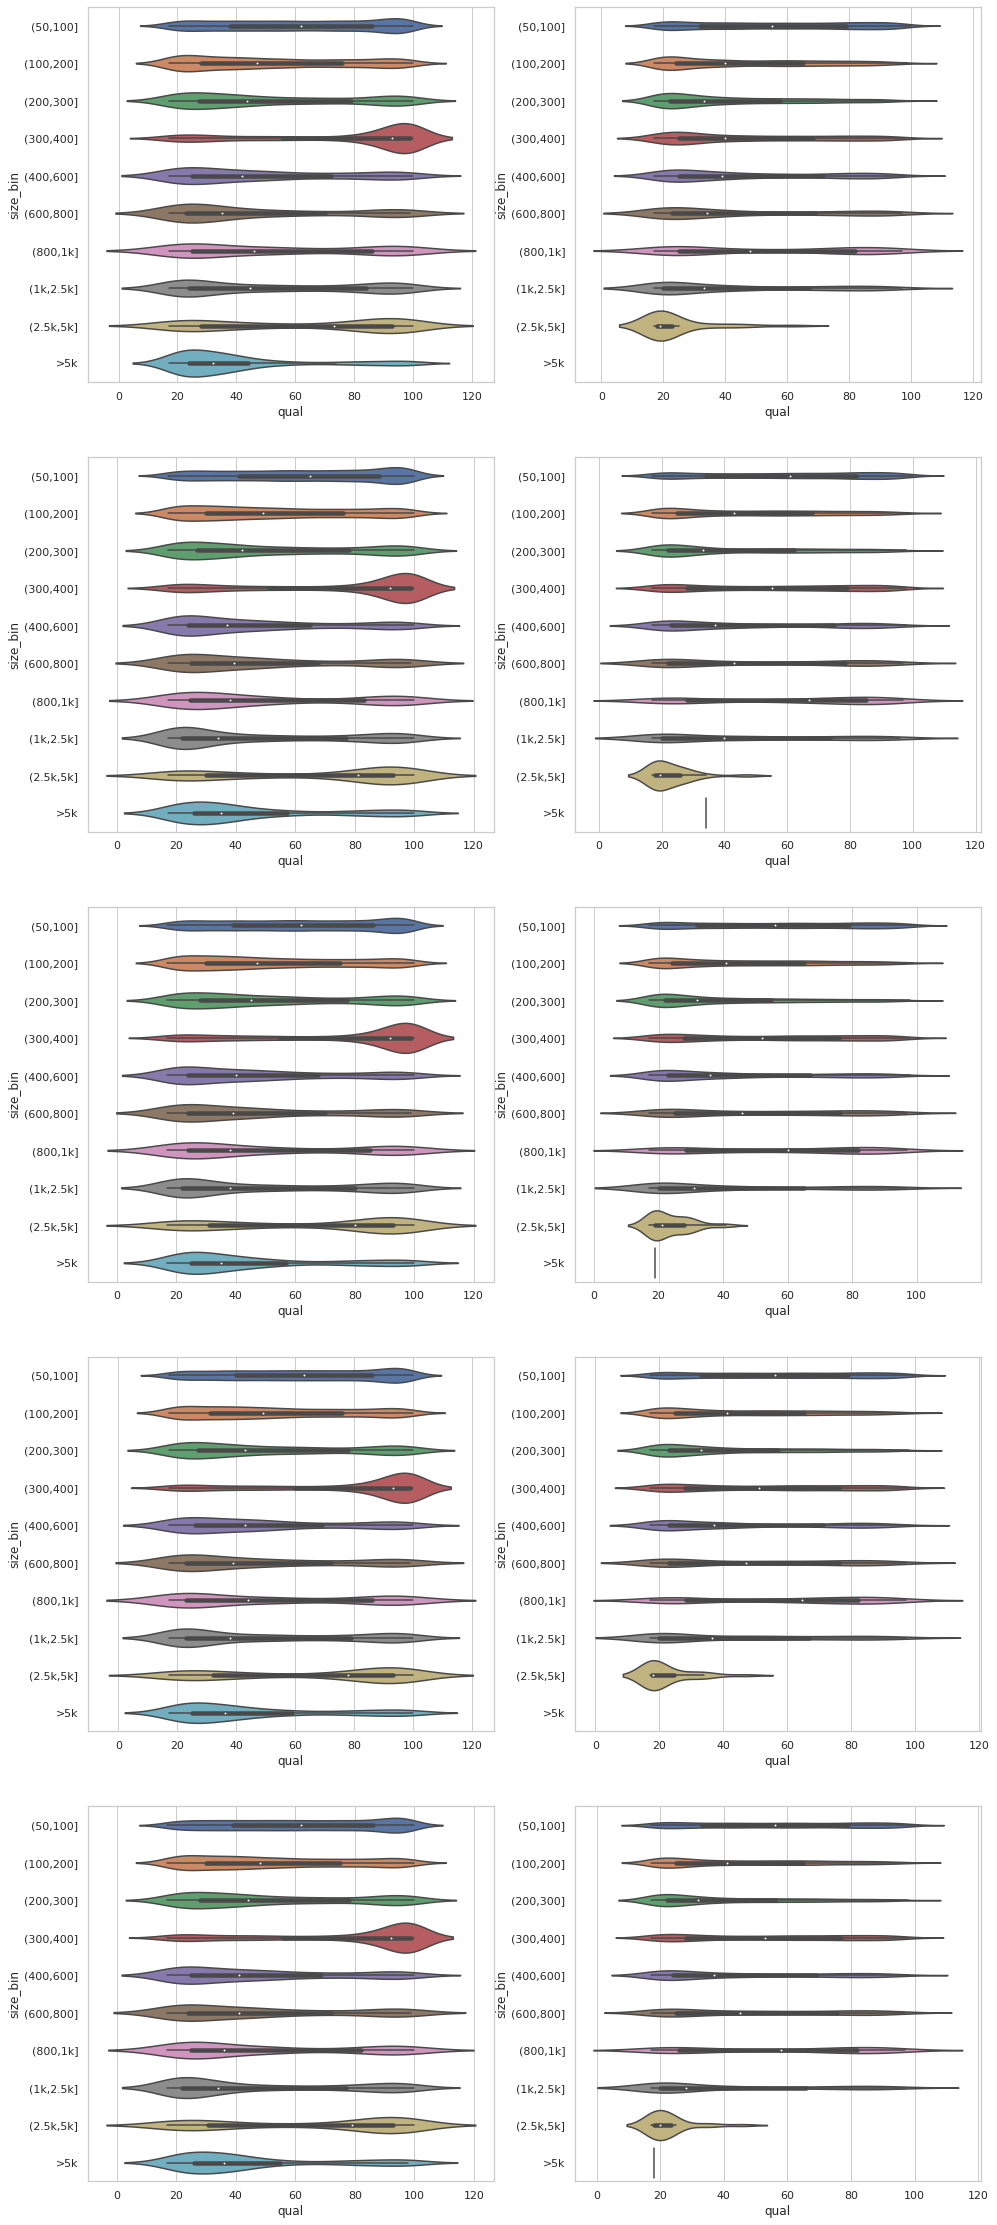

In [101]:
#QUAL SCORE DISTRIBUTIONS ACROSS TYPES/SIZES
all_dat = []
szbintype = CategoricalDtype(categories=SZBINS[1:], ordered=True)
fig, axs = plt.subplots(ncols=2, nrows=len(samps))
fig.set_size_inches((8*2, 8*len(samps)))

for row, i in enumerate(samps): # This is useless because it's the merge.. I think.
    for col, svtype in enumerate([SV.DEL, SV.INS]):
        plt.sca(axs[row, col])
        sub = data[(~data[i+"_gt"].isin([GT.NON.value, GT.UNK.value])) 
                   & (data["size_bin"] != "(0,50]")
                   & (data["svtype"] == svtype.value)]
        sb.violinplot(x=sub["qual"], y=sub["size_bin"].astype(szbintype))
plt.show()


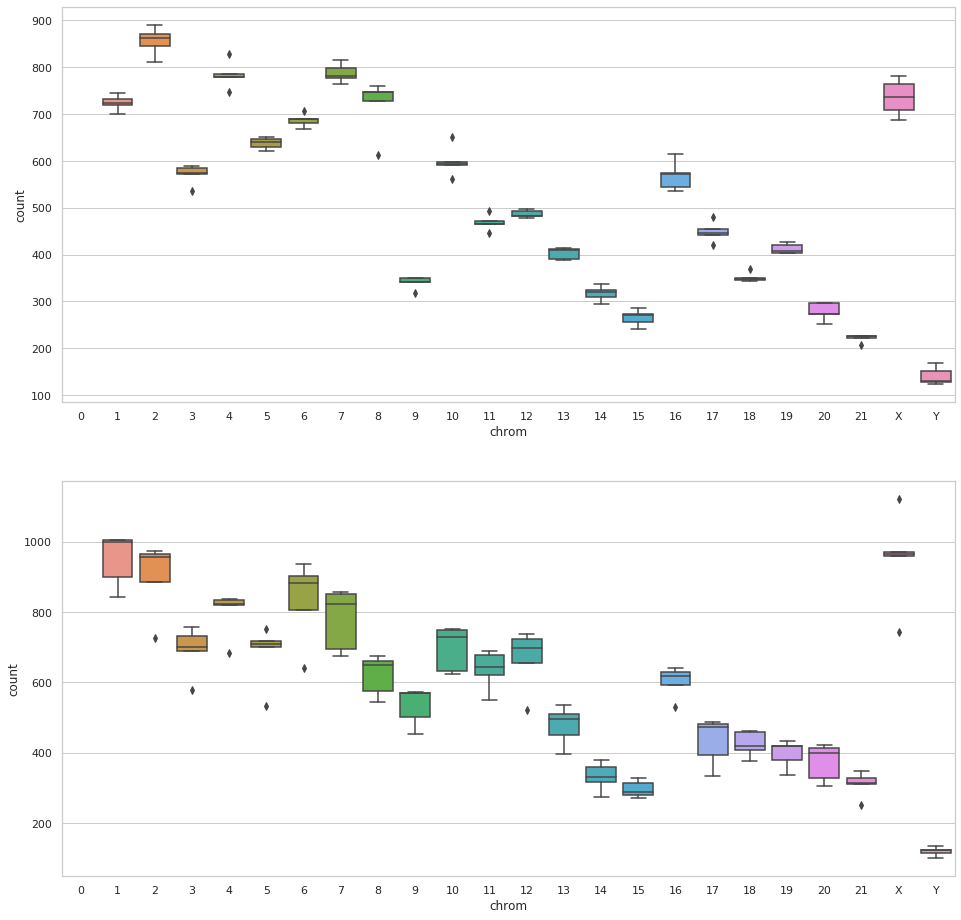

In [107]:
# Box-Plot of SVs per Individual per chromosome by TYPE
fig, axs = plt.subplots(nrows=2)
fig.set_size_inches((8*2, 8*2))
chromtype = CategoricalDtype(categories=[str(x) for x in range(1, 22)] + ["X", "Y"], ordered=True)

for row, t in enumerate([SV.DEL, SV.INS]):
    all_dat = []
    plt.sca(axs[row])
    for i in samps:
        sub = data[(~data[i+"_gt"].isin([GT.NON.value, GT.UNK.value]))
                  & (data["svtype"] == t.value)
                  & (data["size_bin"] != "(0,50]")]
        for key, sub2 in sub.groupby(["chrom"]):
            all_dat.append([key, i, len(sub2)])
    d = pd.DataFrame(all_dat, columns=["chrom", "samp", "count"])
    sb.boxplot(x=d["chrom"].astype(chromtype), y=d["count"])
plt.show()

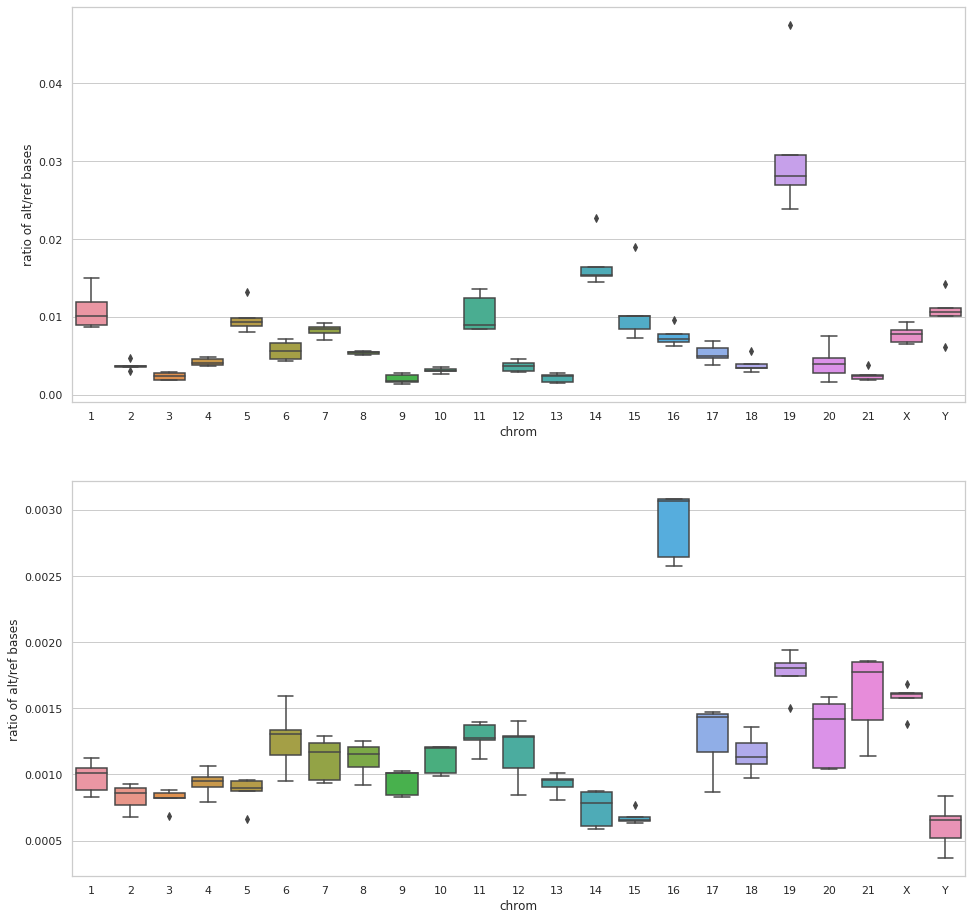

In [108]:
# affected bases normalized by chromosome length
# Box-Plot of SVs per Individual per chromosome by TYPE
fig, axs = plt.subplots(nrows=2)
fig.set_size_inches((8*2, 8*2))
chromtype = CategoricalDtype(categories=[str(x) for x in range(1, 22)] + ["X", "Y"], ordered=True)
from biograph import Reference
ref = Reference("/reference/hs37d5")
for row, t in enumerate([SV.DEL, SV.INS]):
    all_dat = []
    plt.sca(axs[row])
    for i in samps:
        sub = data[(~data[i+"_gt"].isin([GT.NON.value, GT.UNK.value]))
                  & (data["svtype"] == t.value)
                  & (data["size_bin"] != "(0,50]")]
        for key, sub2 in sub.groupby(["chrom"]):
            all_dat.append([key, i, sum(abs(sub2["svlen"])) / ref.scaffold_lens[key]])
    d = pd.DataFrame(all_dat, columns=["chrom", "samp", "ratio of alt/ref bases"])
    sb.boxplot(x=d["chrom"].astype(chromtype), y=d["ratio of alt/ref bases"])
plt.show()

In [118]:
# I want to look at the number of calls per-basepair of regions annoted by their
# grch38 diff
from intervaltree import IntervalTree
from collections import defaultdict
regions = defaultdict(IntervalTree)
with open("hg19.grch38diff.bed") as fh:
    for line in fh:
        line = line.strip().split('\t')
        regions[line[0].replace('chr','')].addi(int(line[1]), int(line[2]), line[4])


In [129]:
def do_intersect(item):
    """ returns csv string of all contig diff scores an item overlaps"""
    return ",".join(set([x.data for x in regions[item["chrom"]].overlap(item["start"], item["end"])]))
data["hg38diff"] = data.apply(do_intersect, axis=1)

In [130]:
# groupby hg38diff, see how many events there are just to start
for i, d in data.groupby(["hg38diff"]):
    print(i, len(d))

 4915293
0 142332
0,500 3
1000 16464
500 1536413
500,0 3


In [160]:
# print(Counter(data[data["hg38diff"] == "0"]["chrom"]))
# SVs overlapping hg38diff 0 regions 
#& (data["filt"] == "PASS")
x = pd.DataFrame(Counter(data[(data["hg38diff"] == "0")    
                              & (data["size_bin"] != "(0,50]")]
                         ["chrom"]).items(), 
                 columns=["chrom", "count"])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


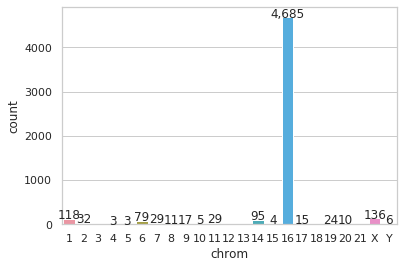

In [161]:
x["chrom"] = x["chrom"].astype(chromtype)
p = sb.barplot(x=x["chrom"].astype(chromtype), y=x["count"])
def show_values_on_bars(axs, fmt='{:.2f}'):
    """ c/o https://stackoverflow.com/a/51535326 """
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = fmt.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(p, fmt="{:,.0f}")        
plt.show()

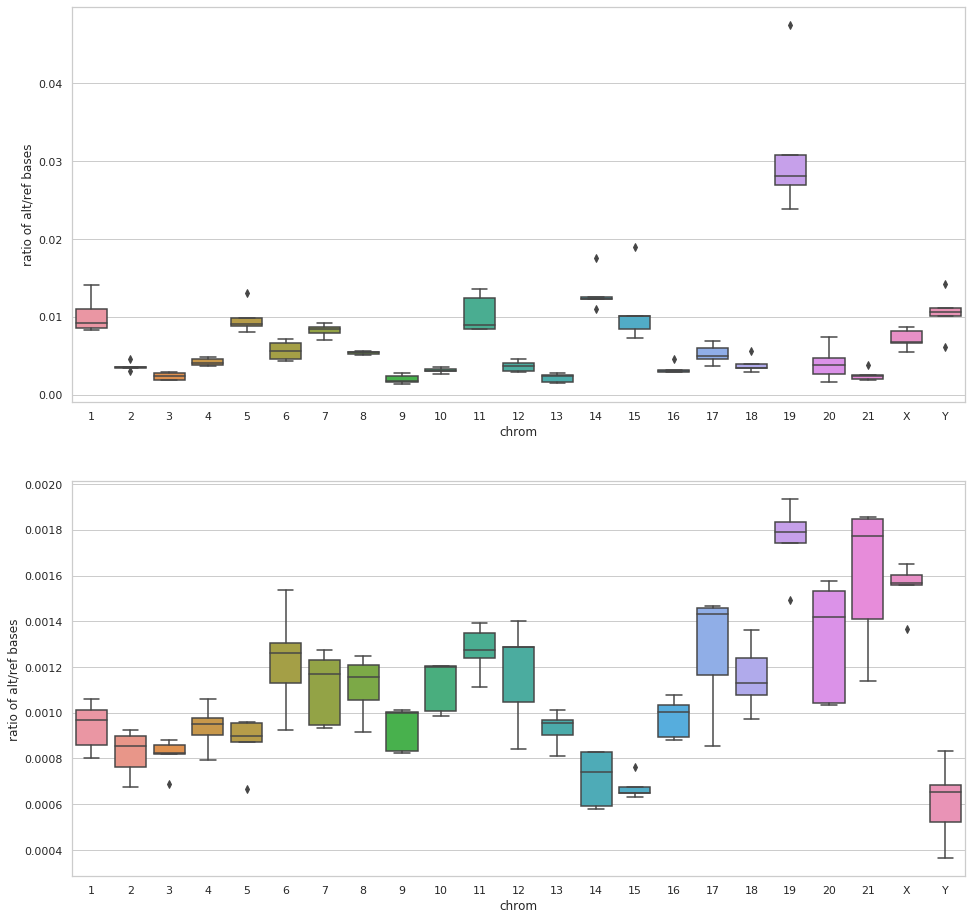

In [168]:

# WITHOUT the diff regions:
# affected bases normalized by chromosome length
# Box-Plot of SVs per Individual per chromosome by TYPE
fig, axs = plt.subplots(nrows=2)
fig.set_size_inches((8*2, 8*2))
chromtype = CategoricalDtype(categories=[str(x) for x in range(1, 22)] + ["X", "Y"], ordered=True)
from biograph import Reference
ref = Reference("/reference/hs37d5")
for row, t in enumerate([SV.DEL, SV.INS]):
    all_dat = []
    plt.sca(axs[row])
    for i in samps:
        sub = data[(~data[i+"_gt"].isin([GT.NON.value, GT.UNK.value]))
                  & (data["svtype"] == t.value)
                  & (data["size_bin"] != "(0,50]")
                  & (data["hg38diff"] != "0")]
        for key, sub2 in sub.groupby(["chrom"]):
            all_dat.append([key, i, sum(abs(sub2["svlen"])) / ref.scaffold_lens[key]])
    d = pd.DataFrame(all_dat, columns=["chrom", "samp", "ratio of alt/ref bases"])
    sb.boxplot(x=d["chrom"].astype(chromtype), y=d["ratio of alt/ref bases"])
plt.show()

In [156]:
Counter(data["filt"])

Counter({'PASS': 6296011, 'lowq': 314497})